In [ ]:
# Install czmodel and dependencies

! pip install --upgrade pip
! pip install scikit-image xmltodict
! pip install onnxruntime
#! pip install cpuonly
! pip install czmodel[pytorch]

## Disclaimer

This content of this repository is free to use for everybody. Carl Zeiss Microscopy GmbH's ZEN software undertakes no warranty concerning the use of those scripts, image analysis settings and ZEN experiments. Use them on your own risk.

**By using any of those examples you agree to this disclaimer.**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from czmodel.pytorch.convert import DefaultConverter
import tempfile
import json
from pathlib import Path
import onnxruntime as onnx_rt
from skimage.io import imread
import random
import sys

In [2]:
# Folder containing the input images
IMAGES_FOLDER = "nucleus_data/images/"

# Folder containing the ground truth regression labels
# Regression labels contain a real number for each pixel
MASKS_FOLDER = "nucleus_data/labels/"

# Path to the data on GitHub
GITHUB_IMAGES_PATH = "https://raw.githubusercontent.com/zeissmicroscopy/cytodata_2022_workshop/main/workshop/notebooks/nucleus_data.zip"

# Path to the tools folder on Github
modelname = "cyto2022_nuc.czann"
CZANN_PATH = r"https://raw.githubusercontent.com/zeissmicroscopy/cytodata_2022_workshop/main/workshop/notebooks/" + modelname

czann_filepath = os.path.join(os.getcwd(), modelname)

### Download data if it's not available on disk

If this notebook is run e.g. as a colab notebook, it does not have access to the data folder on gitub via disk access. In that case we need to download the data from github first.

In [3]:
import requests

# Download training data
if not (os.path.isdir(IMAGES_FOLDER) and os.path.isdir(MASKS_FOLDER)):
    compressed_data = './nucleus_data.zip'
    if not os.path.isfile(compressed_data):
        import io
        response = requests.get(GITHUB_IMAGES_PATH, stream=True)
        compressed_data = io.BytesIO(response.content)
        
    import zipfile
    with zipfile.ZipFile(compressed_data, 'r') as zip_accessor:
        zip_accessor.extractall('./')

# Download czann file.py
if not os.path.isfile('cyto2022_nuc.czann.py'):
    response = requests.get(CZANN_PATH, stream=True)
    with open('cyto2022_nuc.czann', 'wb') as handle:
        handle.write(response.content)

In [4]:
# get the sample images
sample_images = sorted([os.path.join(IMAGES_FOLDER, f) for f in os.listdir(IMAGES_FOLDER)
                        if os.path.isfile(os.path.join(IMAGES_FOLDER, f))])

# get the maks
sample_masks = sorted([os.path.join(MASKS_FOLDER, f) for f in os.listdir(MASKS_FOLDER)
                       if os.path.isfile(os.path.join(MASKS_FOLDER, f))])

In [5]:
def predict_one(sess: onnx_rt.InferenceSession, batch_elem: np.ndarray) -> np.ndarray:
    """Predicts with a batch size of 1 to not risk memory issues.

    Arguments:
        sess: The inference session containing the loaded model.
        batch_elem: One element of a batch to be used for prediction.

    Returns:
        The prediction for the provided batch element.
    """
    batch_elem = batch_elem[np.newaxis]
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    # ONNX can only handle float32
    batch_elem = batch_elem.astype(np.float32)
    input_dict = {input_name: batch_elem}
    result = sess.run([output_name], input_dict)[0]

    return result[0]

In [6]:
# extract the model information and path and to the prediction
with tempfile.TemporaryDirectory() as temp_path:

    # get the model metadata and the path
    model_metadata, model_path = DefaultConverter().unpack_model(model_file=czann_filepath,
                                                                 target_dir=Path(temp_path))

    # get model metadata as dictionary
    model_metadata_dict = model_metadata._asdict()
    for k,v in model_metadata_dict.items():
        print(k, "=", v)

    # get the input shape
    shp = model_metadata.input_shape

    # create an ONNX session and get the input shape
    # use either "CUDAExecutionProvider" or "CPUExecutionProvider"]
    #sess = onnx_rt.InferenceSession(str(model_path), providers=["CPUExecutionProvider"])
    sess = onnx_rt.InferenceSession(str(model_path), providers=[("CUDAExecutionProvider", {"cudnn_conv_algo_search": "DEFAULT"})])

model_type = ModelType.SINGLE_CLASS_SEMANTIC_SEGMENTATION
input_shape = [1024, 1024, 1]
output_shape = [1024, 1024, 2]
model_id = 17276cdb-d00e-4274-a456-d5394f5d3081
min_overlap = [128, 128]
classes = ['background', 'nuc']
model_name = APEER-trained model
scaling = None


Text(0.5, 1.0, 'Label Mask')

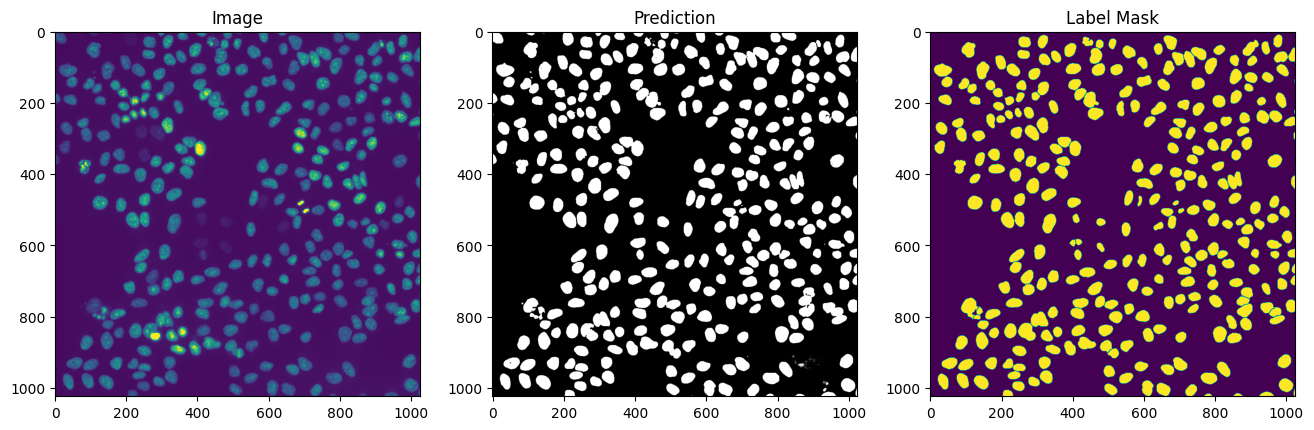

In [7]:
# just re-execute the cell to display a different image
from skimage.io import imread

# select an a random image
id = random.randint(0, len(sample_images))

# read images and scale
img = imread(sample_images[id])/(2**16 - 1)
mask = imread(sample_masks[id])

# cut input to fit the model
img = img[0: shp[0], 0:shp[1]]
mask = mask[0: shp[0], 0:shp[1]]

# run the actual prediction
pred = predict_one(sess, img[..., np.newaxis])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)

# show images and set titles
ax1.imshow(img, vmin=0, vmax=0.05)
ax2.imshow(pred[..., 1], cmap="gray")
ax3.imshow(mask)

ax1.set_title('Image')
ax2.set_title('Prediction')
ax3.set_title('Label Mask')